### Dataset exploration

Aggregate Data

In [22]:
import pandas as pd
from glob import glob

# Load all daily CSVs into a single DataFrame
all_files = glob('../data/daily/http_day_2025-*.csv')
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

/tmp/ipykernel_795393/253106967.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)


Basic Stats Table

In [23]:
summary = {
    'Total Requests': len(df),
    'Unique Client IPs': df['clientIP'].nunique(),
    'Unique Host IPs': df['hostIP'].nunique(),
    'Unique Countries (client)': df['client_country'].nunique(),
    'Unique Countries (host)': df['host_country'].nunique(),
    'Date Range': f"{df['startTime'].min()[:10]} — {df['startTime'].max()[:10]}"
}
print(pd.DataFrame(summary, index=['Stats']).T)


                                             Stats
Total Requests                            32894941
Unique Client IPs                           295094
Unique Host IPs                                271
Unique Countries (client)                      194
Unique Countries (host)                         25
Date Range                 2025-03-15 — 2025-10-15


#### Key Distribution Plots

A. Request Per Day

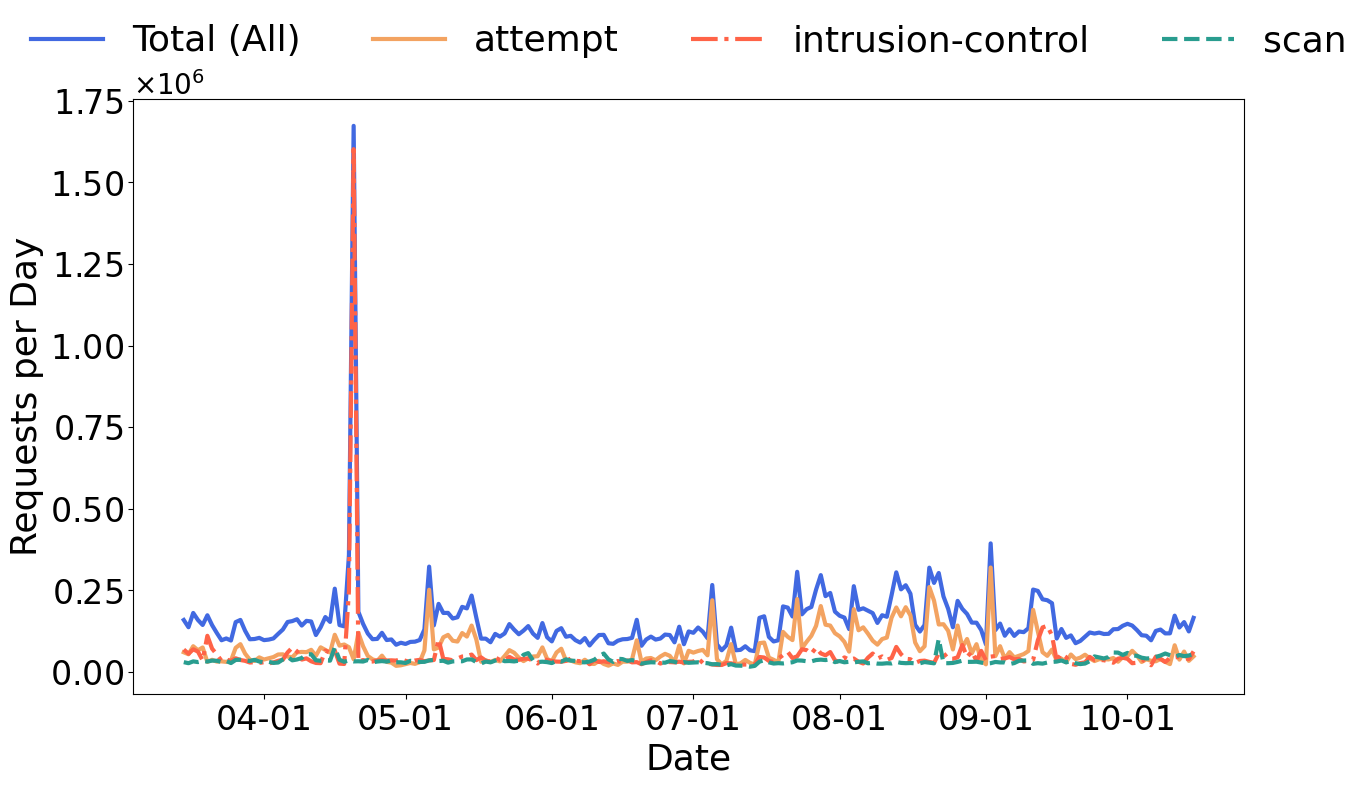

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Prepare date column
df['date'] = pd.to_datetime(df['startTime']).dt.date

# Total volume per day
daily_counts = df.groupby('date').size()

# Volume per day for each category
category_daily_counts = df.groupby(['date', 'category']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))

# Total (all) as solid line
ax.plot(daily_counts.index, daily_counts.values, color='royalblue', linewidth=3, label='Total (All)', linestyle='-')

cat_colors = {
    'scan': '#299d8f',        
    'attempt': '#f3a361',     
    'intrusion-control': 'tomato',  
}
cat_styles = {
    'scan': '--',
    'attempt': '-',
    'intrusion-control': '-.',
}

for cat in category_daily_counts.columns:
    ax.plot(
        category_daily_counts.index,
        category_daily_counts[cat],
        label=cat,
        color=cat_colors.get(cat, 'gray'),
        linestyle=cat_styles.get(cat, '--'),
        linewidth=3
    )

ax.set_ylabel('Requests per Day', fontsize=26)
ax.set_xlabel('Date', fontsize=26)

# Y-axis scientific label, bigger
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6))
ax.yaxis.get_offset_text().set_fontsize(20)

# X-axis: month-day only, no rotation
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
plt.setp(ax.get_xticklabels(), fontsize=24, rotation=0, ha='center')

plt.yticks(fontsize=24)

# Legend (top, no border)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.18),
    ncol=4,
    frameon=False,
    fontsize=26
)

plt.tight_layout()
plt.savefig("../data/dataset/reqvolume.pdf", bbox_inches='tight')
plt.show()


In [8]:
# Find the peak (maximum) in total volume
peak_date = daily_counts.idxmax()
peak_value = daily_counts.max()
print(f"Peak date: {peak_date}, Peak value: {peak_value:,}")


Peak date: 2025-04-20, Peak value: 1,673,302


In [9]:
# Get the top 3 peak dates and volumes
top5 = daily_counts.sort_values(ascending=False).head(5)
print("Top 5 peaks:")
print(top5)


Top 5 peaks:
date
2025-04-20    1673302
2025-09-02     393978
2025-04-19     358403
2025-05-06     322827
2025-08-20     319550
dtype: int64


In [10]:
for date in top5.index:
    print(f"\n{date}:")
    print(category_daily_counts.loc[date])



2025-04-20:
category
attempt                38999
intrusion-control    1601953
scan                   32350
Name: 2025-04-20, dtype: int64

2025-09-02:
category
attempt              320114
intrusion-control     46956
scan                  26908
Name: 2025-09-02, dtype: int64

2025-04-19:
category
attempt               75831
intrusion-control    246763
scan                  35809
Name: 2025-04-19, dtype: int64

2025-05-06:
category
attempt              252007
intrusion-control     35360
scan                  35460
Name: 2025-05-06, dtype: int64

2025-08-20:
category
attempt              260143
intrusion-control     30842
scan                  28565
Name: 2025-08-20, dtype: int64


In [11]:
peak_dates = top5.index  # or just manually: ['2025-04-15', '2025-05-02', '2025-06-28']

In [12]:
print(df.columns)

Index(['protocol', 'category', 'id', 'http_method', 'http_status', 'http_uri',
       'http_body', 'http_accept', 'http_accept_encoding', 'http_user_agent',
       'http_content_type', 'http_referer', 'http_connection',
       'sessionTimeout', 'sessionLength', 'startTime', 'endTime', 'clientIP',
       'client_asn', 'client_as_org', 'client_country', 'hostIP', 'host_asn',
       'host_as_org', 'host_country', 'date'],
      dtype='object')


In [13]:
for date in peak_dates:
    day_df = df[pd.to_datetime(df['startTime']).dt.date == date]
    client_country = day_df['client_country'].value_counts()
    host_country = day_df['host_country'].value_counts()
    print(f"\nPeak Date: {date}")
    print(client_country.head(5))  # Top 5 countries by number of requests
    print(host_country.head(5))  # Top 5 host countries by number of requests


Peak Date: 2025-04-20
client_country
Switzerland        1569149
United States        47299
United Kingdom        9801
The Netherlands       8959
Germany               7775
Name: count, dtype: int64
host_country
India            416550
Japan            369827
Italy            339900
United States    314324
France           132614
Name: count, dtype: int64

Peak Date: 2025-09-02
client_country
United States     123995
Japan              31187
France             30501
United Kingdom     30303
India              25242
Name: count, dtype: int64
host_country
United States    113363
India             47768
Hong Kong         24645
Canada            20883
Australia         19786
Name: count, dtype: int64

Peak Date: 2025-04-19
client_country
Switzerland        213529
United States       47344
Seychelles          32561
The Netherlands     13450
United Kingdom      10428
Name: count, dtype: int64
host_country
United States    79079
India            69537
Italy            60399
Japan            5

In [14]:
import pandas as pd

# Ensure 'date' column exists as datetime.date
df['date'] = pd.to_datetime(df['startTime']).dt.date

# Define period
start_period = pd.to_datetime('2025-05-06').date()
end_period = pd.to_datetime('2025-05-15').date()

# Loop through each day in the range
for d in pd.date_range(start_period, end_period):
    day = d.date()
    day_df = df[df['date'] == day]
    top_clients = day_df['client_country'].value_counts().head(3)
    top_hosts = day_df['host_country'].value_counts().head(3)
    print(f"{day} - Top client countries:\n{top_clients}")
    print(f"{day} - Top host countries:\n{top_hosts}\n")


2025-05-06 - Top client countries:
client_country
Seychelles         231110
United States       29675
The Netherlands     17021
Name: count, dtype: int64
2025-05-06 - Top host countries:
host_country
United States    108754
India             46931
Canada            31886
Name: count, dtype: int64

2025-05-07 - Top client countries:
client_country
United States      41301
Seychelles         34849
The Netherlands    18432
Name: count, dtype: int64
2025-05-07 - Top host countries:
host_country
United States    33531
India            26821
Japan            11462
Name: count, dtype: int64

2025-05-08 - Top client countries:
client_country
Japan            77253
Seychelles       42166
United States    30287
Name: count, dtype: int64
2025-05-08 - Top host countries:
host_country
United States    51691
India            29309
Japan            12988
Name: count, dtype: int64

2025-05-09 - Top client countries:
client_country
Seychelles       78972
United States    24605
Japan            15997
Na

B. Top Countries (Client & Host)

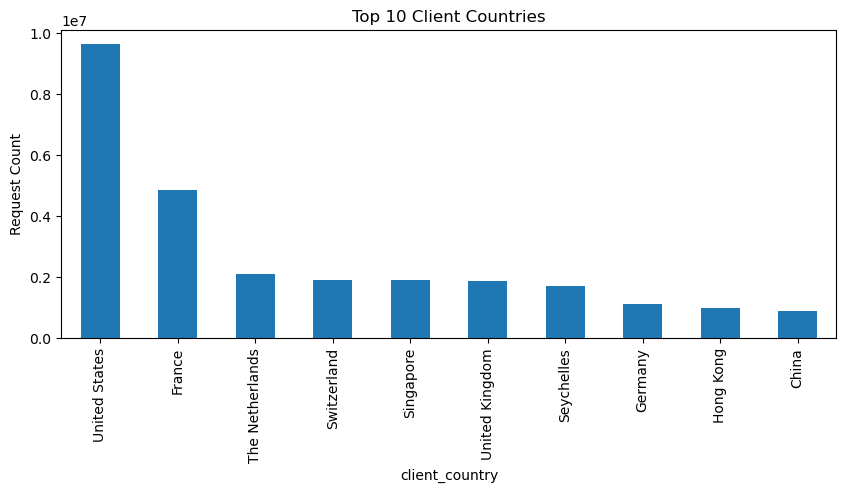

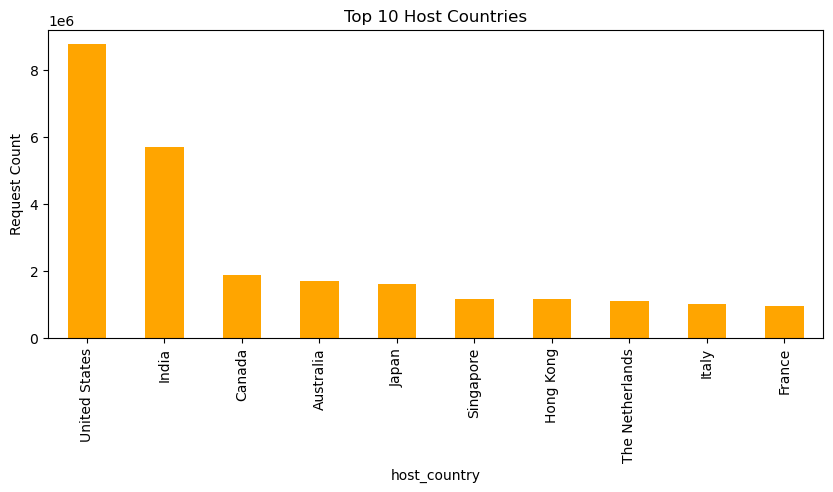

In [15]:
plt.figure(figsize=(10,4))
df['client_country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Client Countries')
plt.ylabel('Request Count')
plt.show()

plt.figure(figsize=(10,4))
df['host_country'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Host Countries')
plt.ylabel('Request Count')
plt.show()

In [16]:
# Get top client countries (adjust to host_country if needed)
top_countries = df['client_country'].value_counts().head(10).index.tolist()

# For each country, list top 2 client_as_org (or host_as_org)
summary = {}
for country in top_countries:
    subset = df[df['client_country'] == country]
    orgs = subset['client_as_org'].value_counts().head(3).index.tolist()
    summary[country] = orgs

# Convert to DataFrame for LaTeX/Markdown formatting
summary_df = pd.DataFrame(summary).T
summary_df.columns = [f'Org {i+1}' for i in range(len(summary_df.columns))]
summary_df.index.name = "Country"
print(summary_df)

                                                 Org 1  \
Country                                                  
United States                    GOOGLE-CLOUD-PLATFORM   
France                                    Bucklog SARL   
The Netherlands                             Pfcloud UG   
Switzerland                          Private Layer INC   
Singapore                           CTG Server Limited   
United Kingdom                     Hostglobal.plus Ltd   
Seychelles                                Bucklog SARL   
Germany                                   Contabo GmbH   
Hong Kong                        POWER LINE DATACENTER   
China            Hangzhou Alibaba Advertising Co.,Ltd.   

                                                             Org 2  \
Country                                                              
United States                                     DIGITALOCEAN-ASN   
France                                                Contabo GmbH   
The Netherlands        

In [17]:
import pandas as pd

# Assuming df is your DataFrame loaded from the CSVs
country_counts = df['host_country'].value_counts().reset_index()
country_counts.columns = ['host_country', 'count']
country_counts.to_csv("../data/dataset/host_country_volume.csv", index=False)
print("✅ Exported to host_country_volume.csv")


✅ Exported to host_country_volume.csv


In [18]:
import pandas as pd
import pycountry

# Your data as a DataFrame
country_df = pd.read_csv("../data/dataset/host_country_volume.csv")  # columns: host_country,count

country_df['host_country'] = country_df['host_country'].replace({
    'The Netherlands': 'Netherlands'
})
# Function to map full country names to ISO2 codes
def country_to_iso2(name):
    try:
        return pycountry.countries.lookup(name).alpha_2
    except LookupError:
        return None

country_df["iso2"] = country_df["host_country"].apply(country_to_iso2)
country_df.to_csv("../data/dataset/host_country_volume.csv", index=False)
# Quick check for any that failed to map
print(country_df[country_df["iso2"].isnull()])

# Now use "iso2" for plotting or annotation if desired

Empty DataFrame
Columns: [host_country, count, iso2]
Index: []


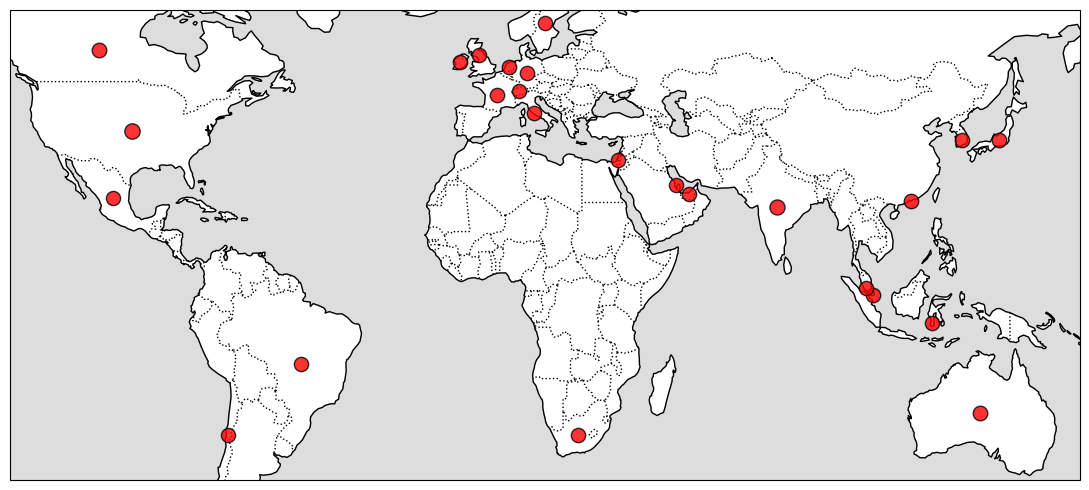

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Country centroid dictionary
coords = {
    'US': (38, -97), 'IN': (21, 78), 'JP': (36, 138), 'CA': (56, -106), 'AU': (-25, 133),
    'IT': (42, 12), 'HK': (22.3, 114.2), 'FR': (46, 2), 'SG': (1.3, 103.8), 'ZA': (-30, 24),
    'DE': (51, 10), 'KR': (36, 128), 'GB': (55, -3), 'NL': (52.2, 5.3), 'IE': (53.3, -8),
    'ID': (-5, 120), 'SE': (62, 15), 'IL': (31.5, 34.75), 'AE': (24, 54), 'BR': (-14, -51),
    'BH': (26, 50.5), 'MY': (3, 102), 'CH': (47, 8), 'CL': (-30, -71), 'MX': (23, -102),
}

# 2. Load your CSV
df = pd.read_csv("../data/dataset/host_country_volume.csv")

# 3. Set up plot settings
fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, 160, -40, 65], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.add_feature(cfeature.LAND, color='white', zorder=0)
ax.add_feature(cfeature.OCEAN, color='#DDDDDD', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

base_size = 10
scale = 0.00035

# 4. Plot dots for each country
for _, row in df.iterrows():
    iso = row['iso2']
    count = row['count']
    if iso in coords:
        lat, lon = coords[iso]
        dot_size = base_size + scale * np.sqrt(count)
        ax.plot(
            lon, lat, marker='o', markersize=dot_size,
            color='red', markeredgecolor='black', alpha=0.8,
            transform=ccrs.PlateCarree()
        )

#plt.title("Global Honeypot Infrastructure Distribution", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("../data/dataset/infrageo.pdf", bbox_inches="tight")
plt.show()


In [20]:
df.head()

,host_country,count,iso2
0,United States,8773005,US
1,India,5695172,IN
2,Canada,1864316,CA
3,Australia,1696078,AU
4,Japan,1593329,JP
